In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from river import stream, compose, metrics, base, preprocessing, optim, naive_bayes, linear_model, tree, forest
from river.neural_net.mlp import MLP
from river.neural_net import activations

import pandas as pd

In [68]:
random_state = np.random.RandomState(seed=42)

def generate_norm_dist(dist_params, base_len=2000):
    dists = []

    for mu, sigma in dist_params:
        t = base_len + random_state.randint(-50, 50)
        dist = random_state.normal(mu, sigma, t)
        dists.append(dist)
    
    return dists

def generate_poisson_dist(dist_params, base_len=2000):
    dists = []

    for lam, _ in dist_params:
        t = base_len + random_state.randint(-50, 50)
        dist = random_state.poisson(lam, t)
        dists.append(dist)

    return dists


In [69]:
dists_params = [[
    (0.3933, 0.0425),
    (0.7389, 0.0543),
    (0.2850, 0.0559),
    (0.8022, 0.0343),
    (0.4031, 0.0550)
],
[   (0.8983, 0.0572),
    (0.2296, 0.0481),
    (0.4913, 0.0771),
    (0.3600, 0.0574),
    (0.1731, 0.0074)]
]


In [70]:
def generate_ys(dist_params, dists):
    ys = None

    for i, ((mu, sigma), xs) in enumerate(zip(dist_params, dists)):
        labels = np.where((xs - mu) > sigma / 2, np.ones_like(xs, dtype=int), np.zeros_like(xs, dtype=int))
        ys = labels if ys is None else np.concat([ys, labels])

    return ys

In [71]:
def get_stream_and_labels(dist_params: list[tuple[int, int]], dist_func: callable) -> tuple[np.ndarray, list[int]]:
    dists = dist_func(dist_params, base_len=5000)
    data_stream = np.concatenate(dists)
    labels = generate_ys(dist_params, dists)
    return data_stream, labels

In [72]:
streams_labels = [
    get_stream_and_labels(dists_params[0], generate_norm_dist),
    get_stream_and_labels(dists_params[1], generate_poisson_dist),
]

In [73]:
n = 20
for i, (data_stream, labels) in enumerate(streams_labels):
    print(f'Data stream: {i}')
    for x, y in stream.iter_array(data_stream[:n, np.newaxis], labels[:n]):
        print(x, y)

Data stream: 0
{0: 0.34604509498300584} 0
{0: 0.40685334284929875} 0
{0: 0.40515925491850585} 0
{0: 0.43624689960427737} 1
{0: 0.3686126793040006} 0
{0: 0.3709802831949287} 0
{0: 0.36901634295544894} 0
{0: 0.35402647939574805} 0
{0: 0.28226666696052194} 0
{0: 0.4336907115018684} 1
{0: 0.4279989159404314} 1
{0: 0.3285352701013259} 0
{0: 0.37510804227251004} 0
{0: 0.36174770942243517} 0
{0: 0.36340788842743516} 0
{0: 0.3023661221167598} 0
{0: 0.36654731416071934} 0
{0: 0.41870311984378583} 1
{0: 0.5020782413191062} 1
{0: 0.41005490342988304} 0
Data stream: 1
{0: 5} 1
{0: 1} 1
{0: 0} 0
{0: 2} 1
{0: 0} 0
{0: 2} 1
{0: 1} 1
{0: 1} 1
{0: 0} 0
{0: 0} 0
{0: 1} 1
{0: 1} 1
{0: 0} 0
{0: 0} 0
{0: 2} 1
{0: 0} 0
{0: 1} 1
{0: 2} 1
{0: 1} 1
{0: 2} 1


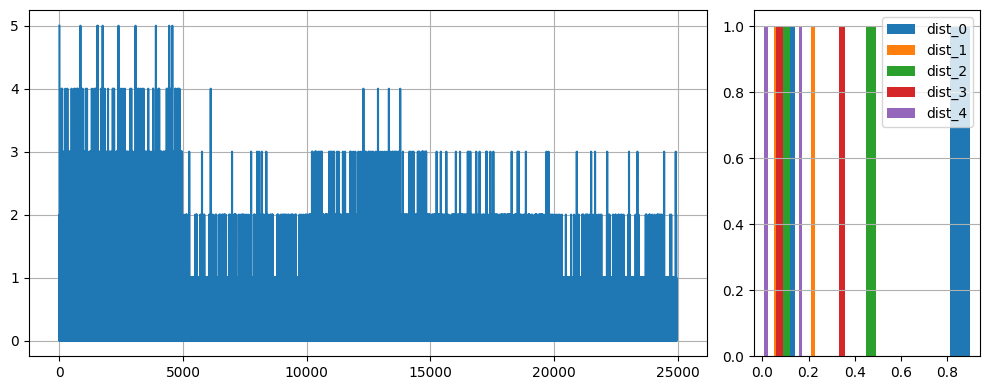

In [74]:
def plot_data(dists, data_stream, drifts=None):
    _ = plt.figure(figsize=(10,4), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    ax1.grid()
    ax1.plot(data_stream, label='Stream')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')

    ax2.grid(axis='y')
    for i, dist in enumerate(dists):
        ax2.hist(dist, label=f'dist_{i}')

    plt.legend()
    plt.show()

plot_data(dists_params[1], streams_labels[1][0])

In [75]:
def plot_history(history, model_name):
    xs = np.arange(len(history))
    plt.plot(xs, history, label="Accuracy")

    plt.title(model_name)
    plt.legend()
    plt.show()

In [76]:
from typing import Type
from river.base import Classifier

def build_and_train_multiple(
    stream_label_pairs: list[tuple[np.ndarray, list[int]]],
    model_name: str,
    model_class: Type[Classifier],
) -> None:
    histories = []

    for data_stream, labels in stream_label_pairs:
        model = compose.Select(0)
        model |= preprocessing.AdaptiveStandardScaler(fading_factor=0.01)
        model |= model_class()

        metric = metrics.Accuracy()
        history = []
        stack = []

        dataset = stream.iter_array(data_stream[:, np.newaxis], labels[:])

        for x, y in dataset:
            model.learn_one(x, y)
            y_pred = model.predict_one(x)

            metric.update(y, y_pred)

            if len(stack) > 250:
                metric.revert(*stack[0])
                stack = stack[1:]

            stack.append((y, y_pred))
            history.append(metric.get())

        histories.append(history)

    fig, axs = plt.subplots(1, len(histories), figsize=(6 * len(histories), 4), sharey=True)

    if len(histories) == 1:
        axs = [axs]

    for i, (ax, history) in enumerate(zip(axs, histories)):
        ax.plot(history, label='Accuracy', color='mediumblue')
        ax.set_title(f"Accuracy over time for stream {i}", fontsize=12, weight='bold')
        ax.set_xlabel("Sample")
        ax.set_ylabel("Accuracy")
        ax.grid(alpha=0.3)
        ax.set_ylim(0, 1.1)
        ax.legend()

    plt.suptitle(f"Accuracy of {model_name}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

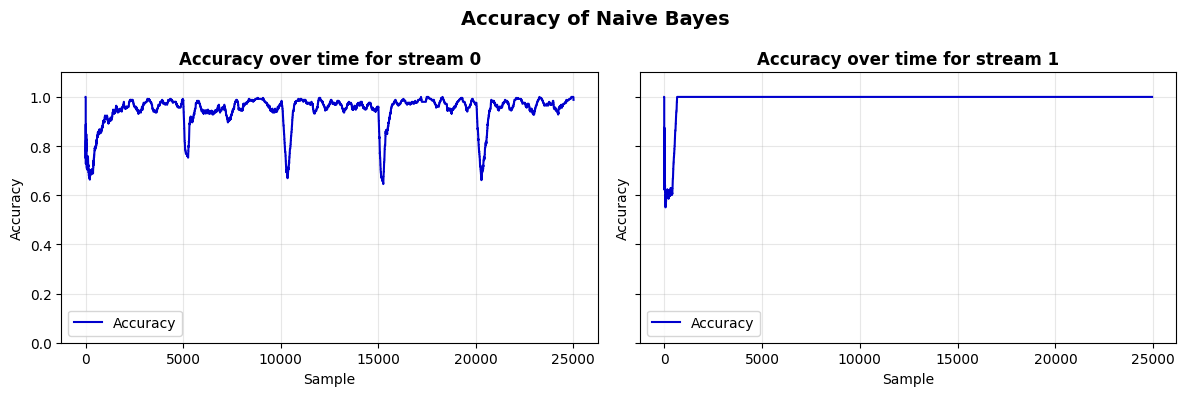

In [77]:
build_and_train_multiple(streams_labels, "Naive Bayes", naive_bayes.GaussianNB)

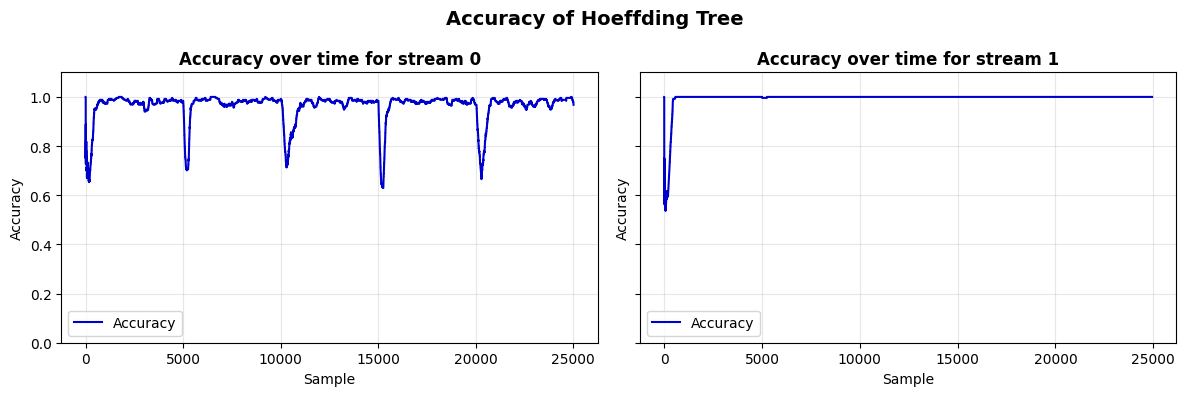

In [78]:
build_and_train_multiple(streams_labels, "Hoeffding Tree", tree.HoeffdingTreeClassifier)

In [79]:
def elm_init(dims: tuple[int, ...], seed: int | None = None):
    rng = np.random.RandomState(seed)

    w = {}  # weights
    b = {}  # biases

    for i in range(len(dims) - 1):
        w[i + 1] = rng.randn(dims[i], dims[i + 1]) / np.sqrt(dims[i + 1])
        b[i + 1] = np.zeros(dims[i + 1], dtype=w[i + 1].dtype)

    return w, b

class ELM(base.Regressor, MLP):
    def __init__(
        self,
        hidden_dims,
        activations,
        X, y,
        loss: optim.losses.Loss | None = None,
        optimizer: optim.base.Optimizer | None = None,
        seed: int | None = None,
    ):
        super().__init__(
            hidden_dims=hidden_dims,
            activations=activations,
            loss=loss or optim.losses.Squared(),
            optimizer=optimizer or optim.SGD(0.01),
            seed=seed,
        )

        self.X = X
        self.y = y

        if isinstance(y, pd.Series):
            y = y.to_frame()

        self.w, self.b = elm_init(
            dims=(X.shape[1], *self.hidden_dims, y.shape[1]), seed=self.seed
        )

        self.features = X.columns.to_numpy()
        self.features.sort()
        self.targets = y.columns.to_numpy()

        H = self._forward(X)[1][2]
        H_pinv = np.linalg.pinv(H)
        self.w[2] = H_pinv.dot(y.to_numpy())

    @classmethod
    def _default_params(self):
        from . import activations

        return {
            "hidden_dims": (20,),
            "activations": (activations.ReLU, activations.ReLU, activations.Identity),
        }

    def predict_many(self, X):
        if not hasattr(self, "w"):
            return pd.DataFrame({0: 0}, index=X.index)
        return self(X)

    def predict_one(self, x):
        y_pred = self.predict_many(X=pd.DataFrame([x]))

        # Multi-output
        if len(y_pred.columns) > 1:
            return y_pred.iloc[0].to_dict()

        # Single output
        return y_pred.iloc[0, 0]
    
    def learn_many(self, X, y):
        pass

    def learn_one(self, x, y):
        pass

class IELM(base.Classifier, MLP):
    def __init__(
        self,
        hidden_dims,
        activations,
        loss: optim.losses.Loss | None = None,
        optimizer: optim.base.Optimizer | None = None,
        k = 10,
        epsilon = 0.05,
        block_size = 200,
        seed: int | None = None,
    ):
        super().__init__(
            hidden_dims=hidden_dims,
            activations=activations,
            loss=loss or optim.losses.Squared(),
            optimizer=optimizer or optim.SGD(0.01),
            
            seed=seed,
        )

        self.k = k
        self.epsilon = epsilon
        self.block_size = block_size
        self.observations = 0
        self.sliding_window = None
        self.last_val_acc = 0.0

        self.classifiers = []

    @classmethod
    def _default_params(self):
        from . import activations

        return {
            "hidden_dims": (20,),
            "activations": (activations.ReLU, activations.ReLU, activations.Identity),
        }

    def predict_many(self, X):
        if len(self.classifiers) == 0:
            return pd.DataFrame({0: 0}, index=X.index)

        votes = None
        total_weight = 0.0
        for classifier in self.classifiers:
            prediction = classifier.predict_many(X).to_numpy() * classifier.weight
            votes = prediction if votes is None else votes + prediction
            total_weight += classifier.weight

        votes /= total_weight

        majority_vote = np.argmax(votes, axis=1)
        return pd.DataFrame(majority_vote)

    def learn_many(self, X, y):
        """Train the network.

        Parameters
        ----------
        X
            A DataFrame of shape (batch_size, n_features).
        y
            A DataFrame of shape (batch_size, n_targets).

        """
        
        # Update sliding window and current block size
        if self.sliding_window is None:
            self.sliding_window = (X, y)
        else:
            X_old, y_old = self.sliding_window
            X_new = pd.concat([X, X_old])[:self.block_size]
            y_new = pd.concat([y, y_old])[:self.block_size]
            self.sliding_window = (X_new, y_new)
        
        self.observations += len(X)

        # Wait until n samples are available to create a new classifier
        if len(self.classifiers) < self.k and self.observations >= self.block_size:
            classifier = ELM(self.hidden_dims, self.activations, *self.sliding_window, self.loss, self.optimizer)
            classifier.weight = 1
            self.classifiers.append(classifier)
            self.observations = 0

        # If there are not yet enough classifiers wait
        if len(self.classifiers) != self.k or self.observations < self.block_size:
            return
        
        # Validate the model on the current sliding window
        metric = metrics.Accuracy()

        preds = {}
        accs = {}
        for classifier in self.classifiers:
            acc = metrics.Accuracy()
            preds[classifier] = classifier(self.sliding_window[0])
            for i in range(len(self.sliding_window[0])):
                acc.update(
                    np.argmax(self.sliding_window[1].iloc[i].to_numpy()),
                    np.argmax(preds[classifier].iloc[i].to_numpy())
                )
            accs[classifier] = acc
        
        y_pred = self.predict_many(self.sliding_window[0])

        for i in range(len(self.sliding_window[0])):
            metric.update(
                np.argmax(self.sliding_window[1].iloc[i].to_numpy()), 
                y_pred.iloc[i][0]
            )

        if metric.get() - self.last_val_acc <= self.epsilon:
            # Update weights for each classifier based on their own accuracy
            for classifier, acc in accs.items():
                print(acc.get())
                classifier.weight = 1 / (1 - acc.get() + 1e-6)
            self.last_val_acc = metric.get()
        else:
            self.classifiers = list(map(lambda pair: pair[0], sorted(accs.items(), key=lambda item: item[1])[:self.k//2]))
            self.last_val_acc = 0.0

    def learn_one(self, x, y):
        # Multi-output
        if isinstance(y, dict):
            self.learn_many(X=pd.DataFrame([x]), y=pd.DataFrame([y]))
            return

        # Single output
        self.learn_many(X=pd.DataFrame([x]), y=pd.Series([y]))

    def predict_one(self, x):
        y_pred = self.predict_many(X=pd.DataFrame([x]))

        # Multi-output
        if len(y_pred.columns) > 1:
            return y_pred.iloc[0].to_dict()

        # Single output
        return y_pred.iloc[0, 0]

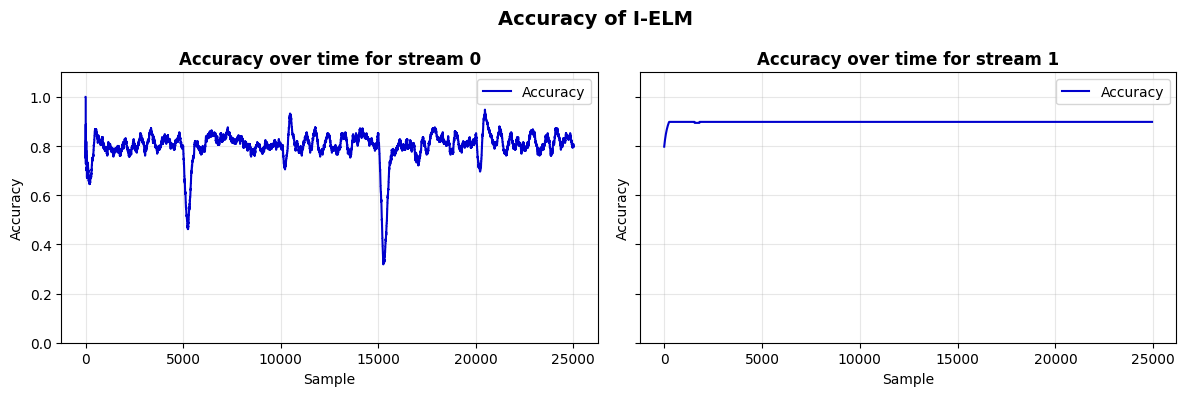

In [87]:
def train_and_plot_ielm(input_data) -> None:
    model = compose.Select(0)
    model |= preprocessing.AdaptiveStandardScaler(fading_factor=0.01)
    model |= IELM(hidden_dims=(200,), activations=(activations.Identity, activations.Sigmoid, activations.Identity))

    metric = metrics.Accuracy()

    histories = [[] for _ in range(len(input_data))]
    for i, (inp_stream, labels) in enumerate(input_data):
        onehot_labels = np.zeros((labels.size, labels.max() + 1))
        onehot_labels[np.arange(labels.size), labels] = 1
        dataset = stream.iter_array(inp_stream[:, np.newaxis], onehot_labels)

        stack = []
        for x, one_hot in dataset:
            y = sorted(one_hot.items(), key=lambda item: item[1])[-1][0]

            model.learn_one(x, one_hot)
            y_pred = model.predict_one(x)

            metric.update(y, y_pred)
            if len(stack) > 250:
                metric.revert(*stack[0])
                stack = stack[1:]
            stack.append((y, y_pred))

            histories[i].append(metric.get())

    fig, axs = plt.subplots(1, len(histories), figsize=(6 * len(histories), 4), sharey=True)

    if len(histories) == 1:
        axs = [axs]

    for i, (ax, history) in enumerate(zip(axs, histories)):
        ax.plot(history, label='Accuracy', color='mediumblue')
        ax.set_title(f"Accuracy over time for stream {i}", fontsize=12, weight='bold')
        ax.set_xlabel("Sample")
        ax.set_ylabel("Accuracy")
        ax.grid(alpha=0.3)
        ax.set_ylim(0, 1.1)
        ax.legend()

    plt.suptitle(f"Accuracy of I-ELM", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

train_and_plot_ielm(streams_labels)

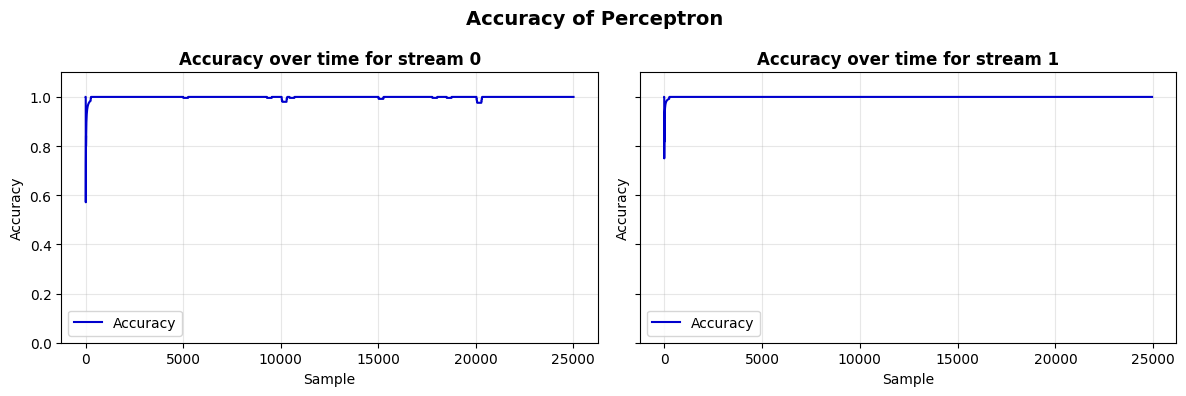

In [81]:
build_and_train_multiple(streams_labels, "Perceptron", linear_model.Perceptron)

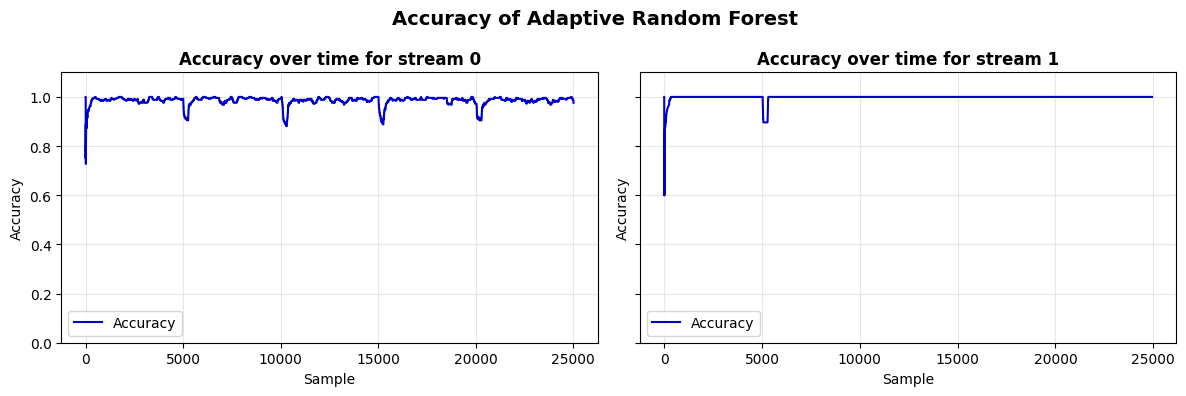

In [82]:
build_and_train_multiple(streams_labels, "Adaptive Random Forest", forest.ARFClassifier)

In general, most approaches showed great accuracy in classifying both input streams.
Perceptron was the most consistent with near 100% accuracy for most of the points in streams.
This strong performance can be attributed to the simplicity and linearity of the underlying data distributions, which align well with the Perceptron's linear decision boundaries. In contrast, models like Gaussian Naive Bayes exhibited slightly more variability, likely due to their assumptions about feature independence and distribution shape, which may not fully hold in the data. Additionally, Hoeffding Tree, while powerful for evolving data, required more observations to stabilize, leading to slower initial convergence but decent final accuracy (on each stream "pump").
All classifies behave similarly on both poisson and normal input sets.